In [5]:
#DATASET GENERATION

import pandas as pd
import numpy as np

# Reproducibility
np.random.seed(42)
 
data = []
samples = 2000  # change if you want more

for _ in range(samples):
    num_pages = np.random.randint(5, 50)
    memory_size = np.random.randint(2, 12)
    locality = np.round(np.random.uniform(0.05, 0.95), 2) 
    sequence_len = np.random.randint(20, 200)

    frames_to_pages = memory_size / num_pages
    freq_var = np.random.uniform(0.1, 1.0) * (1 - locality)

    # rule-based label
    if locality < 0.3 and frames_to_pages < 0.25:
        best_algo = "FIFO"
    elif 0.3 <= locality < 0.7:
        best_algo = "LRU"
    else:
        best_algo = "Optimal"

    data.append([num_pages, memory_size, locality, sequence_len,
                 frames_to_pages, freq_var, best_algo])

df = pd.DataFrame(data, columns=[
    "num_pages","memory_size","locality","sequence_len",
    "frames_to_pages","freq_var","best_algo"
])

print("Dataset created. Distribution:")
print(df["best_algo"].value_counts())
df.head()



Dataset created. Distribution:
best_algo
LRU        893
Optimal    833
FIFO       274
Name: count, dtype: int64


,num_pages,memory_size,locality,sequence_len,frames_to_pages,freq_var,best_algo
0,43,5,0.91,126,0.116279,0.072155,Optimal
1,25,8,0.45,94,0.320000,0.282328,LRU
2,40,9,0.69,169,0.225000,0.046739,LRU
3,28,7,0.05,40,0.250000,0.622947,Optimal
4,26,10,0.31,78,0.384615,0.317314,LRU


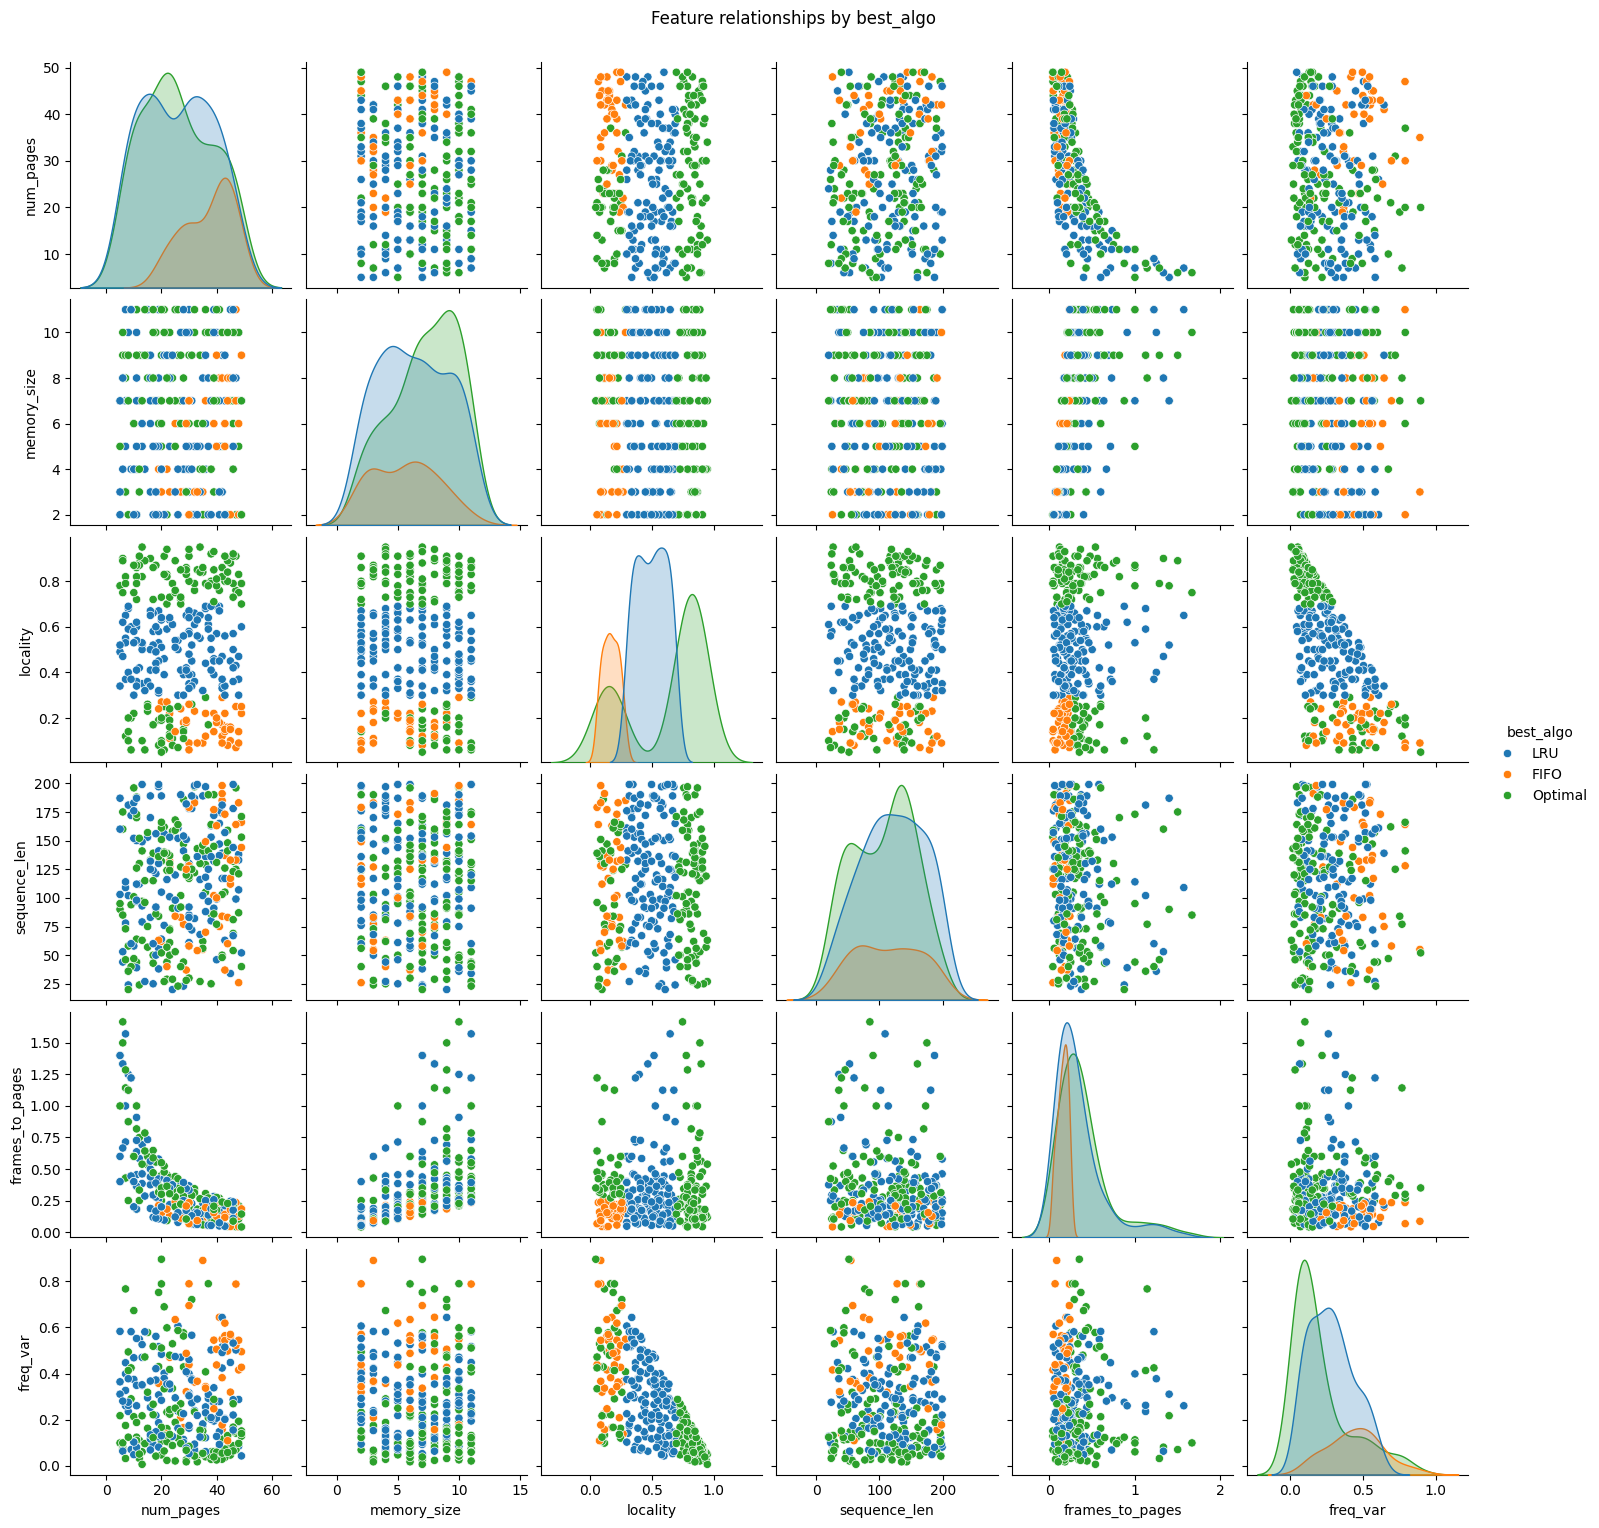

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df.sample(300), hue="best_algo", diag_kind="kde")  # sample to speed up
plt.suptitle("Feature relationships by best_algo", y=1.02)
plt.show()


In [10]:
#PREPROCESSING (FOR CLEAN,NUMERIC,STANDARIZED INPUT)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

features = ["num_pages","memory_size","locality","sequence_len","frames_to_pages","freq_var"]
X = df[features]
y = df["best_algo"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Preprocessing done. Shapes:", X_train.shape, X_test.shape)


Preprocessing done. Shapes: (1600, 6) (400, 6)


In [11]:
#MODEL TRAIN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

models = {
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = (model, acc)
    print(f"\n{name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

best_name = max(results, key=lambda k: results[k][1])
best_model = results[best_name][0]
print(f"\nSelected best model: {best_name} (acc={results[best_name][1]:.3f})")



RandomForest Accuracy: 1.000
              precision    recall  f1-score   support

        FIFO       1.00      1.00      1.00        55
         LRU       1.00      1.00      1.00       179
     Optimal       1.00      1.00      1.00       166

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


LogisticRegression Accuracy: 0.645
              precision    recall  f1-score   support

        FIFO       0.83      0.78      0.80        55
         LRU       0.61      0.67      0.64       179
     Optimal       0.63      0.57      0.60       166

    accuracy                           0.65       400
   macro avg       0.69      0.67      0.68       400
weighted avg       0.65      0.65      0.64       400


Selected best model: RandomForest (acc=1.000)


In [12]:
import joblib

joblib.dump(best_model, "best_algo_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Saved: best_algo_model.pkl, label_encoder.pkl, scaler.pkl")


Saved: best_algo_model.pkl, label_encoder.pkl, scaler.pkl


In [13]:
#MANUALLY PREDICTION OF MODEL
import pandas as pd
# sample: [num_pages, memory_size, locality, sequence_len]
sample = [20, 4, 0.6, 80]
frames_to_pages = sample[1] / sample[0]
freq_var = 0.8 * (1 - sample[2])  # or set logic similar to generator
df_input = pd.DataFrame([[sample[0], sample[1], sample[2], sample[3], frames_to_pages, freq_var]],
                        columns=features)

scaled = scaler.transform(df_input)
pred = best_model.predict(scaled)
print("Predicted:", le.inverse_transform(pred)[0])


Predicted: LRU


In [15]:
#FOR SCROLLABLE ELEMENTS
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import joblib

# load saved models (if you restarted kernel)
model = joblib.load("best_algo_model.pkl")
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

num_pages = widgets.IntSlider(value=10, min=5, max=50, step=1, description="No. Pages:")
memory_size = widgets.IntSlider(value=3, min=2, max=12, step=1, description="Frames:")
locality = widgets.FloatSlider(value=0.5, min=0.05, max=0.95, step=0.05, description="Locality:")
sequence_len = widgets.IntSlider(value=50, min=10, max=200, step=10, description="Seq Len:")
out = widgets.Output()

def predict_algo(btn):
    with out:
        clear_output()
        frames_to_pages = memory_size.value / max(1, num_pages.value)
        freq_var = 0.8 * (1 - locality.value)
        df_input = pd.DataFrame([[num_pages.value, memory_size.value, locality.value, sequence_len.value,
                                  frames_to_pages, freq_var]], columns=features)
        scaled = scaler.transform(df_input)
        pred = model.predict(scaled)
        print("Predicted Best Algorithm:", le.inverse_transform(pred)[0])

button = widgets.Button(description="Predict Best Algorithm", button_style='success')
button.on_click(predict_algo)

display(num_pages, memory_size, locality, sequence_len, button, out)


IntSlider(value=10, description='No. Pages:', max=50, min=5)

IntSlider(value=3, description='Frames:', max=12, min=2)

FloatSlider(value=0.5, description='Locality:', max=0.95, min=0.05, step=0.05)

IntSlider(value=50, description='Seq Len:', max=200, min=10, step=10)

Button(button_style='success', description='Predict Best Algorithm', style=ButtonStyle())

Output()